## LIBRARIES NEEDED


In [3]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.io import loadmat

# Visualization for missing data
import missingno as msno

# Scikit-learn tools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# SHAP for explainability
# import shap
# from shap import TreeExplainer

## FILE LOADING


In [133]:
#load the raw dataset i.e milling in ,mat foramt
mat = loadmat('mill.mat') 
mill = mat['mill']
mill.shape

(1, 167)

In [134]:
# Process the data to create a DataFrame
records = []
for i in range(mill.shape[1]):
    entry = mill[0, i]
    meta = [
        entry[0][0][0],  # case
        entry[1][0][0],  # run
        entry[2][0][0],  # VB
        entry[3][0][0],  # time
        entry[4][0][0],  # DOC
        entry[5][0][0],  # feed
        entry[6][0][0]   # material
    ]

    # Get all 6 signal channels (columns 7-12)
    signals = [entry[j].flatten() for j in range(7, 13)]

    # Find the maximum length among all signals
    max_length = max(len(s) for s in signals)

    # Pad shorter signals with NaN if needed
    signals_padded = []
    for s in signals:
        if len(s) < max_length:
            s = np.pad(s, (0, max_length - len(s)),
                       mode='constant', constant_values=np.nan)
        signals_padded.append(s)

    # Create records for each time point
    for t in range(max_length):
        signal_values = [s[t] for s in signals_padded]
        records.append(meta + signal_values)

# Create a DataFrame
columns = [
    'case', 'run', 'VB', 'time', 'DOC', 'feed', 'material', # copy the simple values of initial 7 column names
    'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle' # flattendata to .csv file
]

data = pd.DataFrame(records, columns=columns)

# Write to CSV
data.to_csv('mill_data.csv', index=False)

## Loading the Dataset

In [4]:
df=pd.read_csv('mill_data.csv')
df.shape

(1509360, 13)

## EXPLORERATORY DATA ANALYSIS (EDA)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509360 entries, 0 to 1509359
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   case         1509360 non-null  int64  
 1   run          1509360 non-null  int64  
 2   VB           1314000 non-null  float64
 3   time         1509360 non-null  int64  
 4   DOC          1509360 non-null  float64
 5   feed         1509360 non-null  float64
 6   material     1509360 non-null  int64  
 7   smcAC        1509360 non-null  float64
 8   smcDC        1509360 non-null  float64
 9   vib_table    1509360 non-null  float64
 10  vib_spindle  1509360 non-null  float64
 11  AE_table     1509360 non-null  float64
 12  AE_spindle   1509360 non-null  float64
dtypes: float64(9), int64(4)
memory usage: 149.7 MB


In [240]:
df.head()

,case,run,VB,time,DOC,feed,material,smcAC,smcDC,vib_table,vib_spindle,AE_table,AE_spindle
0,1,1,0.0,2,1.5,0.5,1,-0.017090,0.625000,0.078125,0.314941,0.087280,0.103760
1,1,1,0.0,2,1.5,0.5,1,0.263672,0.810547,0.085449,0.301514,0.098267,0.123291
2,1,1,0.0,2,1.5,0.5,1,0.207520,0.781250,0.078125,0.303955,0.092163,0.104980
3,1,1,0.0,2,1.5,0.5,1,0.302734,0.849609,0.073242,0.300293,0.095215,0.111084
4,1,1,0.0,2,1.5,0.5,1,0.239258,1.098633,0.083008,0.299072,0.083008,0.092163


In [241]:
df.describe()

,case,run,VB,time,DOC,feed,material,smcAC,smcDC,vib_table,vib_spindle,AE_table,AE_spindle
count,1.509360e+06,1.509360e+06,1.314000e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06
mean,8.344808e+00,7.141676e+00,3.376027e-01,2.600795e+01,1.031742e+00,3.732907e-01,1.345842e+00,2.103678e+23,-5.632651e+14,6.311065e+23,2.770805e+28,-6.893067e+27,-2.802224e+23
std,4.746539e+00,4.960135e+00,2.596345e-01,2.323086e+01,3.632190e-01,1.249884e-01,4.756421e-01,1.126554e+27,3.817644e+17,1.049831e+27,4.157843e+31,3.053705e+31,1.317981e+25
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,7.500000e-01,2.500000e-01,1.000000e+00,-1.587606e+29,-3.696429e+19,-1.587617e+29,-1.044562e+34,-1.040523e+34,-6.201736e+26
25%,3.000000e+00,3.000000e+00,1.500000e-01,7.000000e+00,7.500000e-01,2.500000e-01,1.000000e+00,-1.401367e+00,4.125977e+00,5.541992e-01,2.722168e-01,1.367188e-01,1.641846e-01
50%,1.000000e+01,6.000000e+00,2.850000e-01,1.900000e+01,7.500000e-01,2.500000e-01,1.000000e+00,-1.464844e-01,6.044922e+00,8.276367e-01,2.893066e-01,1.770020e-01,2.154541e-01
75%,1.200000e+01,1.000000e+01,4.700000e-01,3.900000e+01,1.500000e+00,5.000000e-01,2.000000e+00,1.071777e+00,8.369141e+00,1.120605e+00,3.137207e-01,2.307129e-01,2.856445e-01
max,1.600000e+01,2.300000e+01,1.530000e+00,1.050000e+02,1.500000e+00,5.000000e-01,2.000000e+00,1.587607e+29,3.696438e+19,1.587619e+29,1.044565e+34,1.040523e+34,1.249390e+00


195360


<Axes: >

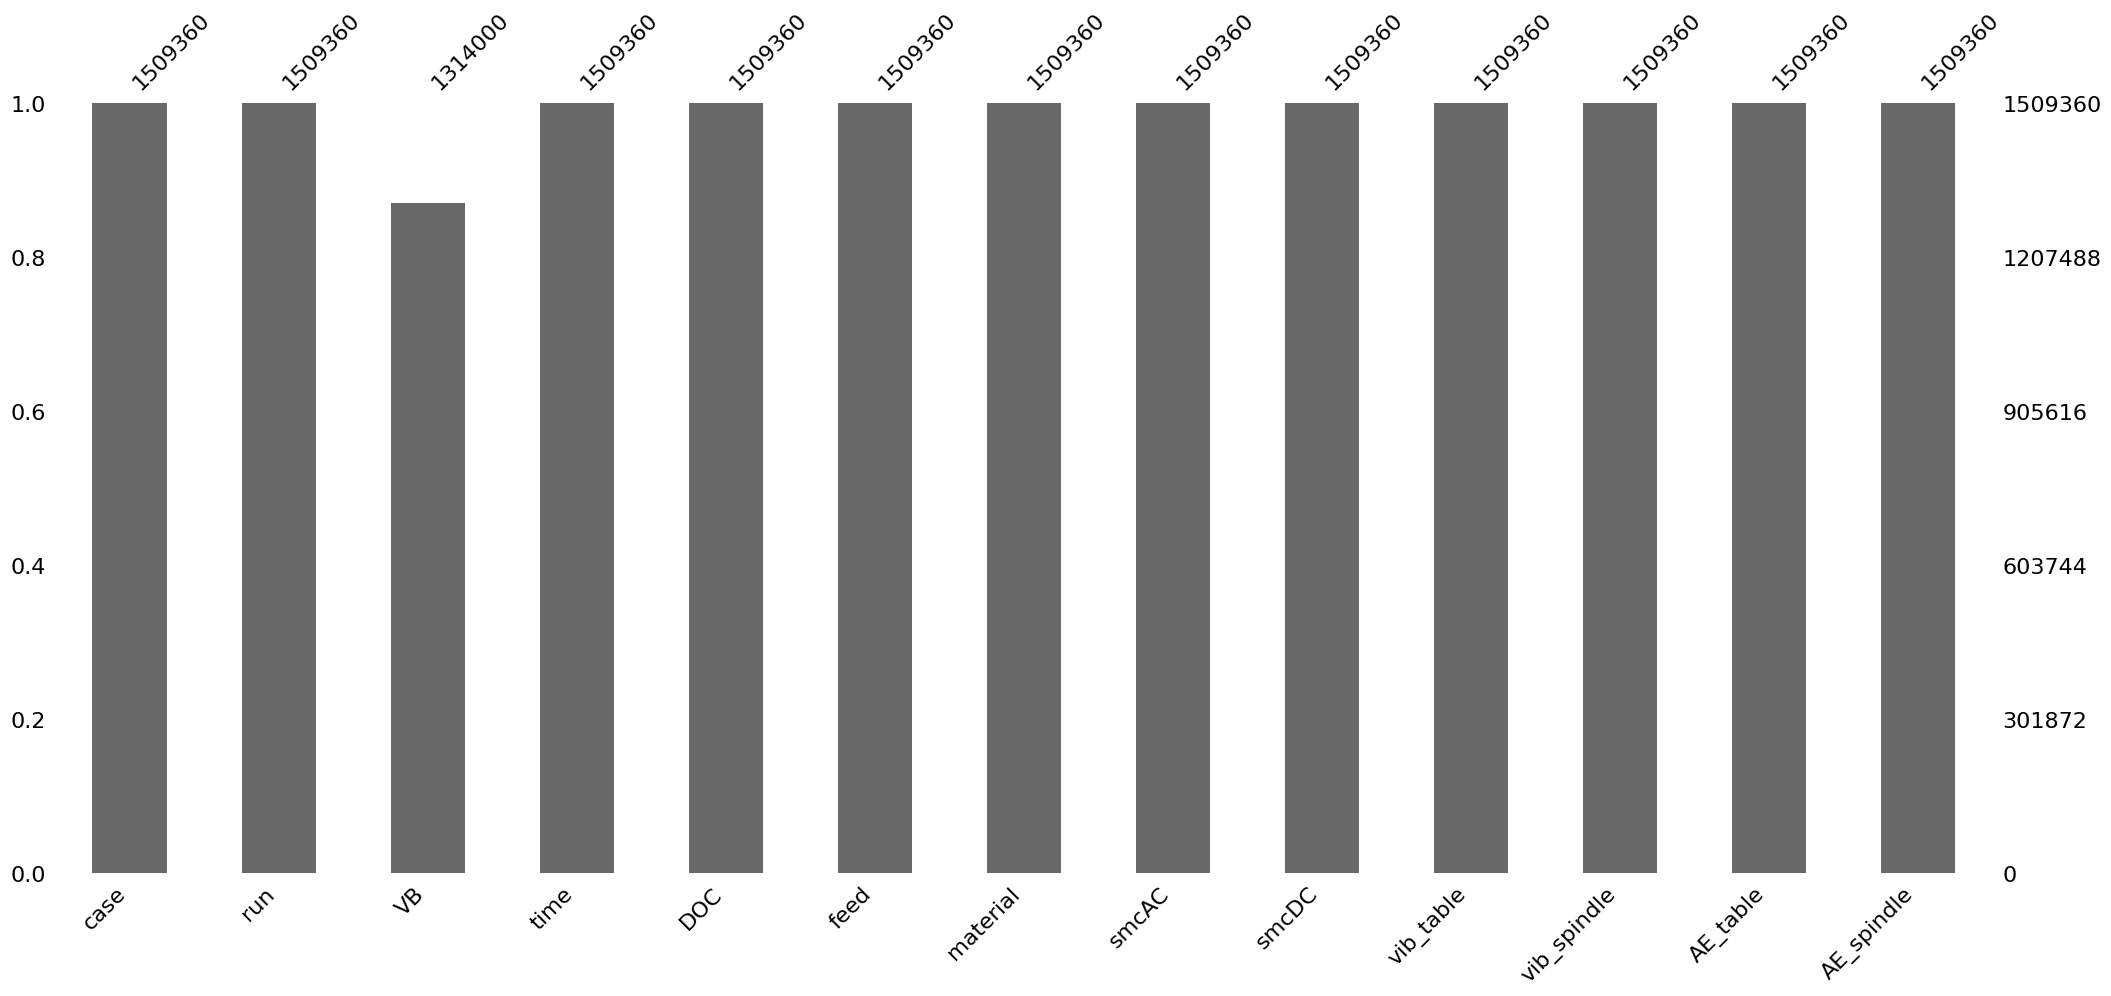

In [242]:
print(df['VB'].isna().sum())
msno.bar(df)

In [243]:
df.duplicated().sum()

np.int64(27)

In [244]:
print(df.columns.tolist())


['case', 'run', 'VB', 'time', 'DOC', 'feed', 'material', 'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle']


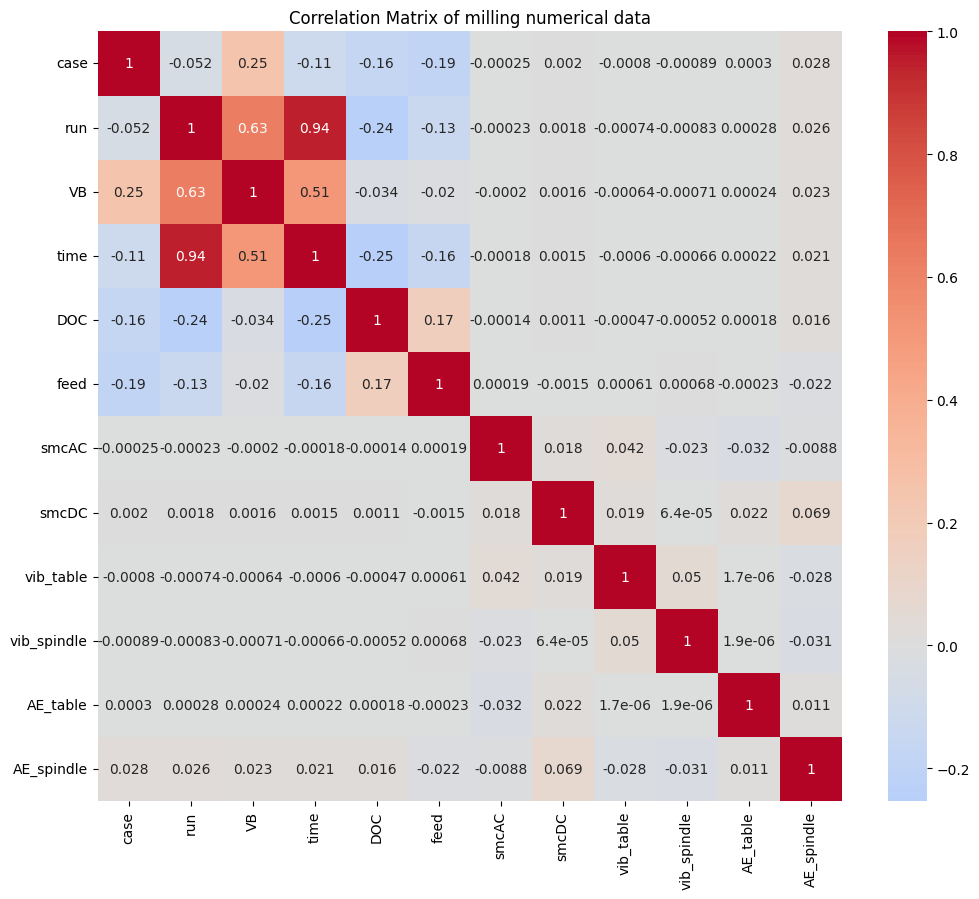

In [245]:
import pandas as pd


# Drop non-numeric (categorical) columns
non_categorical = df.drop(columns=['material'])  # Assuming 'material' is categorical

# Compute correlation matrix for numeric features
corr_matrix = non_categorical.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of milling numerical data')
plt.show()


**VISUALIZATION****

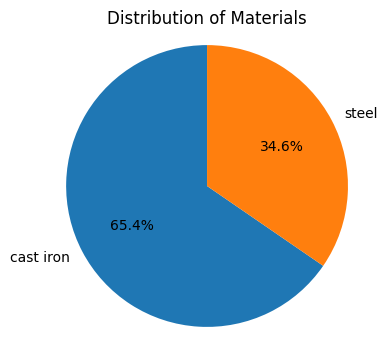

In [246]:
# Count the occurrences of each material
material_counts = df['material'].value_counts()

# Map the numerical labels to material names
material_labels = {1: 'cast iron', 2: 'steel'}
labels = [material_labels[i] for i in material_counts.index]

# Create the pie chart
plt.figure(figsize=(4,4))
plt.pie(material_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Materials')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [247]:
df.shape

(1509360, 13)

getting the outlier percentage

In [255]:
# Sensor columns to analyze
sensor_cols = ["run","case","time","DOC","feed",'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle']

# Calculate outlier percentages
outlier_percentages = {}
for col in sensor_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds (1.5*IQR is the typical boxplot threshold)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_pct = (len(outliers) / len(df)) * 100
    
    outlier_percentages[col] = outlier_pct

# Convert to DataFrame for clear visualization
outlier_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier %'])
outlier_df.sort_values('Outlier %', ascending=False)

,Outlier %
vib_spindle,10.203530
AE_spindle,2.705716
vib_table,2.489532
AE_table,2.312172
run,1.788838
time,1.788838
smcAC,0.483119
smcDC,0.010733
case,0.000000
DOC,0.000000


The high outlier % in vib_spindle could be due to tool wear, chipping, poor cutting conditions, or machine resonance.

# EOL

Detailed Explanation of EOL (End-of-Life) Detection
1. What is EOL (End-of-Life)?
EOL refers to the final operational phase of a material before failure, characterized by:

Accelerated degradation (e.g., rising vibrations, increased acoustic emissions)

Higher frequency of anomalies

Irreversible wear (e.g., tool breakage, bearing collapse)

In [8]:
# Calculate percentiles for late-stage time
time_threshold = df['time'].quantile(0.75)  # Last 25% of recorded time

# Define vibration threshold (e.g., 95th percentile)
vib_threshold = df['vib_spindle'].quantile(0.95)

# Define EOL condition
df["EOL"] = ((df['time'] >= time_threshold) & 
                  (df['vib_spindle'] >= vib_threshold)).astype(int)

print(df.head(3))
df['EOL'].value_counts()

   case  run   VB  time  DOC  feed  material     smcAC     smcDC  vib_table  \
0     1    1  0.0     2  1.5   0.5         1 -0.017090  0.625000   0.078125   
1     1    1  0.0     2  1.5   0.5         1  0.263672  0.810547   0.085449   
2     1    1  0.0     2  1.5   0.5         1  0.207520  0.781250   0.078125   

   vib_spindle  AE_table  AE_spindle  EOL  
0     0.314941  0.087280    0.103760    0  
1     0.301514  0.098267    0.123291    0  
2     0.303955  0.092163    0.104980    0  


EOL
0    1506383
1       2977
Name: count, dtype: int64

Time threshold: 75th percentile of time (i.e., last 25% of process duration).

Vibration threshold: 95th percentile of vib_spindle.

A point is flagged as EOL = 1 if both conditions are met.

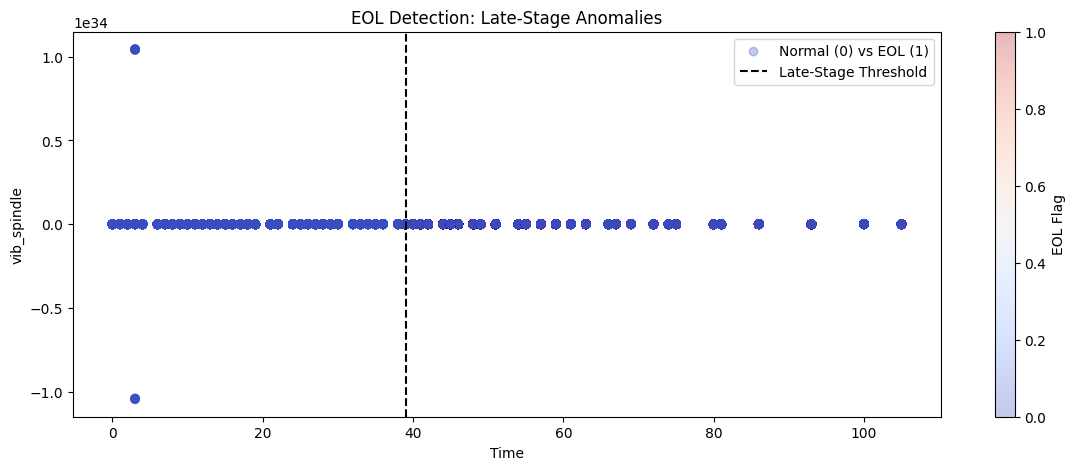

In [260]:
plt.figure(figsize=(14, 5))
plt.scatter(
    df['time'], 
    df['vib_spindle'], 
    c=df['EOL'], 
    cmap='coolwarm', 
    alpha=0.3,
    label='Normal (0) vs EOL (1)'
)
plt.axvline(time_threshold, color='black', linestyle='--', label='Late-Stage Threshold')
plt.xlabel('Time')
plt.ylabel('vib_spindle')
plt.title('EOL Detection: Late-Stage Anomalies')
plt.legend()
plt.colorbar(label='EOL Flag')
plt.show()

X-axis: Time

Y-axis: vib_spindle

Color: red (EOL=1), blue (EOL=0)

Vertical dashed line: Late-stage time threshold (75th percentile)

🔍 Interpretation:
Only a small number of data points exceed both thresholds → only a few EOL events detected.

The vib_spindle signal seems mostly flat (likely due to outliers or bad values like ±1e34).

The late-stage condition seems too strict, especially if sensor noise or scale issues are present.

Value counts show:
EOL

0    1506383

1       2977



--- Cast Iron Trend-Based Analysis ---


C:\Users\abhos\AppData\Local\Temp\ipykernel_24168\1310934513.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


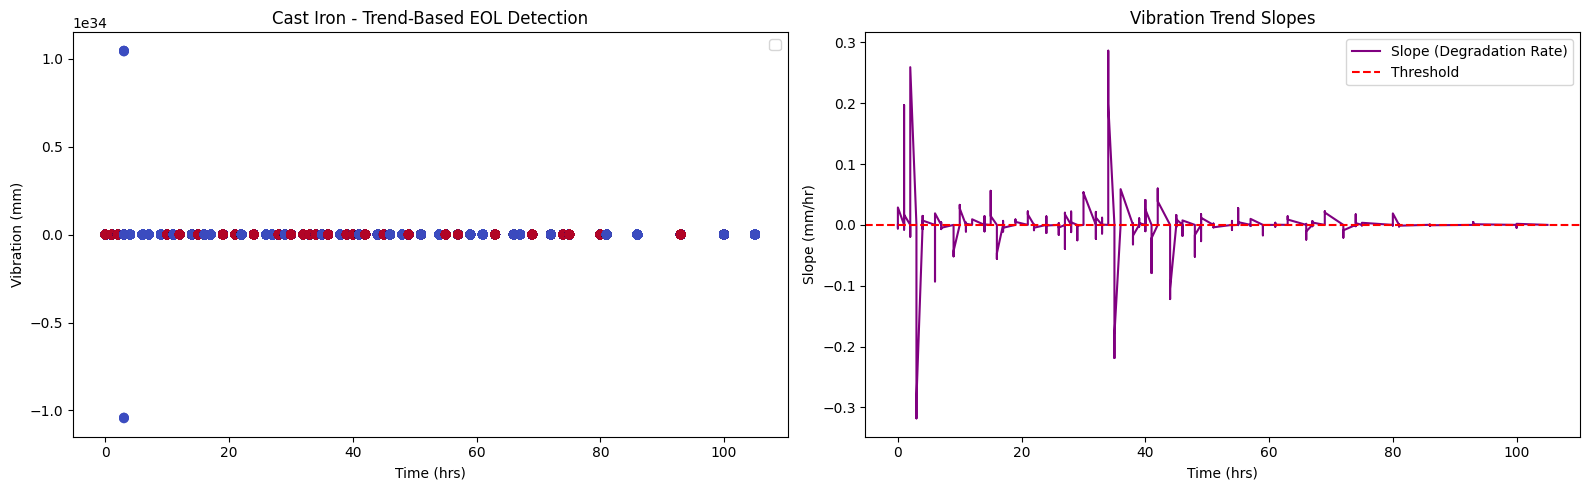

EOL flags (Trend-Based): 2456 out of 987360
Max degradation rate: 0.286199 mm/hr


In [9]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

def analyze_material_trend(df, material_code, material_name, window_size=50, slope_threshold=0.001):
    print(f"\n--- {material_name} Trend-Based Analysis ---")
    
    # Filter material data
    mat_df = df[df['material'] == material_code].copy().sort_values('time')
    
    # 1. Trend analysis: Rolling linear regression
    slopes = []
    for i in range(len(mat_df) - window_size):
        window = mat_df.iloc[i:i+window_size]
        X = window['time'].values.reshape(-1, 1)
        y = window['vib_spindle'].values
        model = LinearRegression().fit(X, y)
        slopes.append(model.coef_[0])  # Slope = rate of vibration increase
    
    # Pad slopes to match original DataFrame length
    slopes = np.concatenate([slopes, [np.nan] * window_size])
    mat_df['slope'] = slopes
    
    # 2. Flag EOL based on sustained positive slopes (degradation)
    mat_df['is_rising'] = mat_df['slope'] > slope_threshold
    mat_df['EOL_trend'] = mat_df['is_rising'].rolling(window=window_size, min_periods=1).mean() > 0.5
    
    # 3. Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # Vibration + Trend Slopes
    ax1.scatter(mat_df['time'], mat_df['vib_spindle'], c=mat_df['EOL_trend'], cmap='coolwarm', alpha=0.4)
    ax1.set_title(f'{material_name} - Trend-Based EOL Detection')
    ax1.set_xlabel('Time (hrs)')
    ax1.set_ylabel('Vibration (mm)')
    ax1.legend()
    
    # Slope plot
    ax2.plot(mat_df['time'], mat_df['slope'], color='purple', label='Slope (Degradation Rate)')
    ax2.axhline(slope_threshold, color='red', linestyle='--', label='Threshold')
    ax2.set_title('Vibration Trend Slopes')
    ax2.set_xlabel('Time (hrs)')
    ax2.set_ylabel('Slope (mm/hr)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    eol_count = mat_df['EOL_trend'].sum()
    print(f"EOL flags (Trend-Based): {eol_count} out of {len(mat_df)}")
    print(f"Max degradation rate: {np.nanmax(mat_df['slope']):.6f} mm/hr")
    
    return mat_df

# Run trend analysis
cast_iron_trend_df = analyze_material_trend(df, 1, 'Cast Iron', window_size=100, slope_threshold=0.0005)


Left: Vibration over Time
Blue = normal

Red = trend-based EOL

Shows scatter of vib_spindle values across time

Right: Slope over Time
Purple line = rolling slope

Red dashed line = slope threshold (0.0005 mm/hr)

🔍 Interpretation:
Even with noisy or flat data, slope analysis catches dynamic degradation.

Many slopes > 0.0005 → implies degrading behavior.



--- Steel Trend-Based Analysis ---


C:\Users\abhos\AppData\Local\Temp\ipykernel_24168\1310934513.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


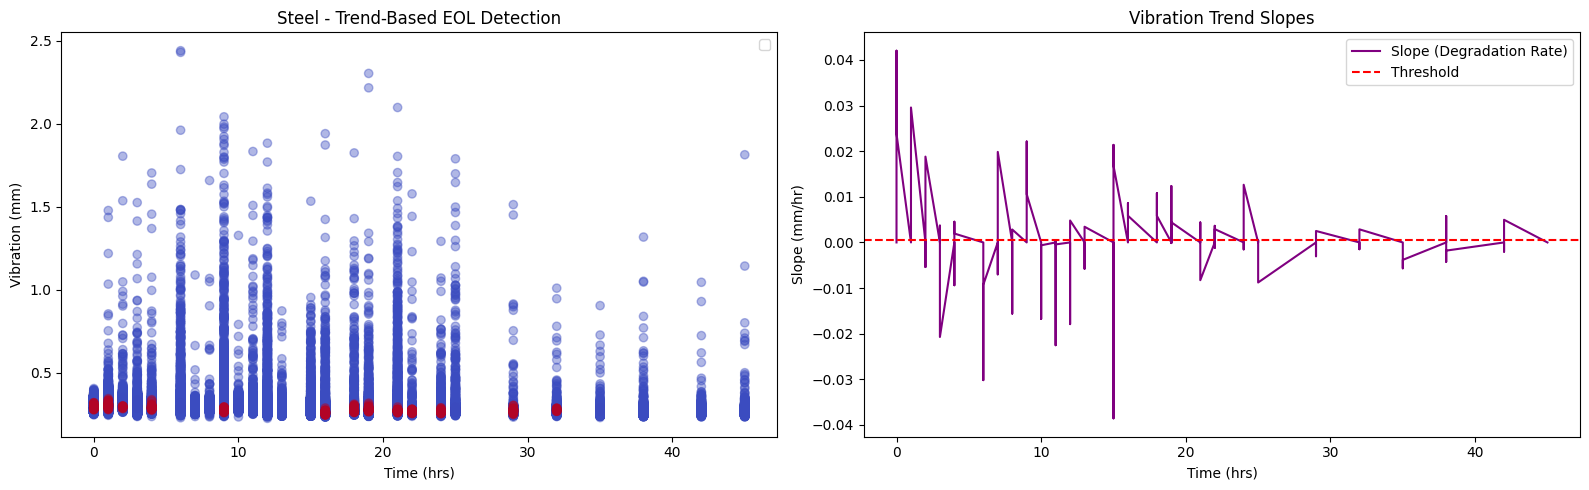

EOL flags (Trend-Based): 1025 out of 522000
Max degradation rate: 0.042009 mm/hr


In [10]:
steel_trend_df = analyze_material_trend(df, 2, 'Steel', window_size=100, slope_threshold=0.0005)

1. Cast Iron - Trend-Based EOL Detection
Left Panel: Vibration vs. Time
Scatter Plot: Shows raw vibration measurements (vib_spindle in mm) over time.

Color Coding:

Blue: Normal operation (EOL_trend = False).

Red: EOL-flagged points (EOL_trend = True).

Key Features:

Points are flagged based on sustained upward trends .

Clusters of red points indicate periods of accelerated wear.

Right Panel: Vibration Trend Slopes
Line Plot: Tracks the degradation rate (slope in mm/hr) calculated via rolling linear regression.

Purple Line: Slope values (positive = increasing vibration, negative = decreasing).

Red Dashed Line: Threshold for EOL flagging (e.g., slope > 0.0005 mm/hr).

Interpretation:

A slope crossing the red threshold triggers EOL flags in the left panel.

Stable processes show near-zero slopes; failure precursors show rising trends.

2. Steel - Trend-Based Analysis
Common Patterns
Vibration Scatter Plot (Left):

Similar to Cast Iron but likely with different vibration amplitudes (steel typically causes higher vibrations due to hardness).

EOL flags (red) correlate with prolonged high-slope periods in the right panel.

Slope Plot (Right):

Steel may show:

Higher baseline slopes (faster wear due to abrasive chips).

More volatility (intermittent spikes from hard inclusions).

<Figure size 1000x600 with 0 Axes>

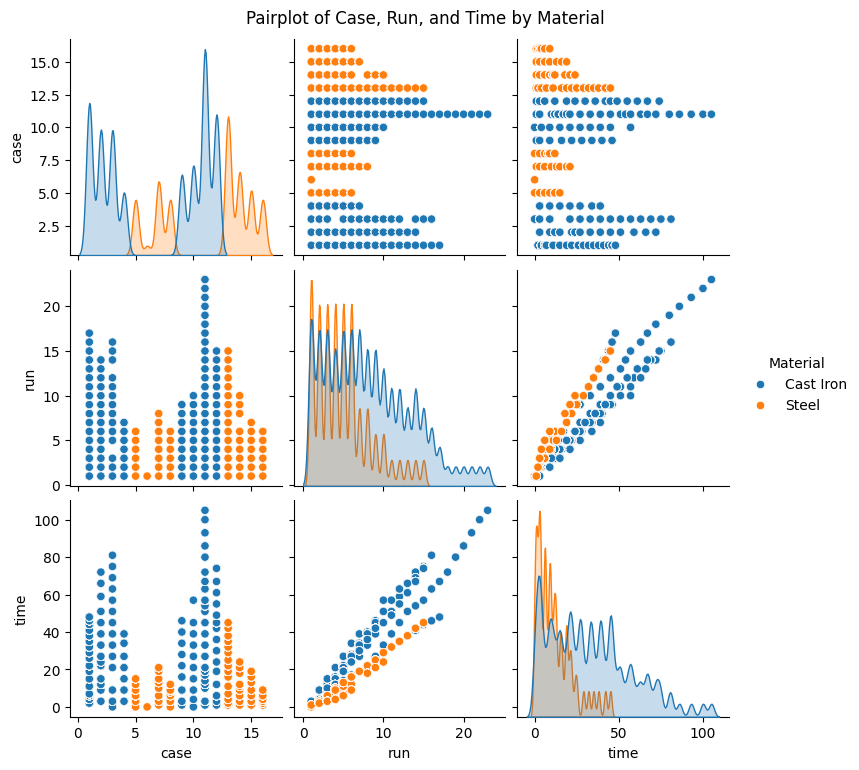

In [16]:
# Include 'material' column and make a proper copy to avoid SettingWithCopyWarning
feature_columns = ['case', 'run', 'time', 'material']
graph1 = df[feature_columns].copy() 

# Map material codes to names
graph1['Material'] = graph1['material'].map({1: 'Cast Iron', 2: 'Steel'})

# Plot with hue using the readable Material labels
plt.figure(figsize=(10,6))
sns.pairplot(graph1[['case', 'run', 'time', 'Material']], hue='Material')
plt.suptitle('Pairplot of Case, Run, and Time by Material', y=1.02)
plt.show()

**1. case vs case (Top-left Diagonal)**
Histogram / KDE plot of case by material:

Cast Iron (blue): Peaks around case 2–4, 11–12.
Steel (orange): Peaks more at higher case numbers — case 13.
Inference: Distribution of case numbers differs by material; Cast_iron is tested more at higher case values.

**2. case vs run**
Scatterplot:

Cast Iron: Spread across all case values, with a wider run range (up to ~24).
Steel: Concentrated in case > 6, and most run values < 15.
Inference: Cast Iron tests involve more runs and broader case range. Steel is more focused in fewer test cases.

**3. case vs time**
Scatterplot:

Cast Iron has points across entire time range (including > 100).
Steel mostly below time = 50.
Inference: Cast Iron typically takes longer per case; Steel is faster or involves less processing time.

**4. run vs run (Diagonal)**
Histogram / KDE plot of run by material:

Cast Iron: Smooth, wide spread, more values above 10.
Steel: Peaks sharply around 5–10, drops quickly.
Inference: Steel has more uniform, lower run counts. Cast Iron tests are longer and more varied.

**5.  run vs time**
Strong linear trend for both materials.
Cast Iron has higher values of both run and time.
Inference: More runs → longer times. Cast Iron may be less efficient or under more extensive testing.


**6.  time vs time (Diagonal)**

Histogram / KDE plot of time by material:
Cast Iron: Long tail — some values exceed 100.
Steel: Most under 50.
Inference: Cast Iron has more time-intensive operations or failure patterns; Steel is quicker.

In [ ]:
import pandas as pd

def get_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Separate data
cast_iron = df[df["material"] == 1].copy()
steel = df[df["material"] == 2].copy()

# Get outliers for each material
outliers_cast_iron = get_outliers(cast_iron, "vib_spindle")
outliers_steel = get_outliers(steel, "vib_spindle")

print(f"Cast Iron Outliers: {len(outliers_cast_iron)} rows ({len(outliers_cast_iron)/len(cast_iron)*100:.2f}%)")
print(f"Steel Outliers: {len(outliers_steel)} rows ({len(outliers_steel)/len(steel)*100:.2f}%)")

Cast Iron Outliers: 132346 rows (13.40%)
Steel Outliers: 7576 rows (1.45%)


# Data Preprocessing

# CLEANING

In [20]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.drop(columns="EOL",inplace=True)

In [21]:
df.shape

(1314000, 13)

In [25]:
# Exclude 'material' column for VIF calculation
features_for_vif = [col for col in df.columns if col != 'material']

vif_df = pd.DataFrame()
vif_df["feature"] = features_for_vif
vif_df["VIF"] = [variance_inflation_factor(df[features_for_vif].values, i) for i in range(len(features_for_vif))]

print(vif_df)

        feature       VIF
0          case  0.244914
1           run  0.305364
2            VB  0.371646
3          time  0.418933
4           DOC  0.110255
5          feed  0.103886
6         smcAC  1.003886
7         smcDC  1.006099
8     vib_table  1.005555
9   vib_spindle  1.004098
10     AE_table  1.001597
11   AE_spindle  1.006283


Since non of the values are greater than 2.all are close to <=1. Thus no collinarity in the features.


In [ ]:
# Define your input features
X = df.drop(['VB',"run"], axis=1) #droping 'run' as it is feature correreles with "time" but an identifier
y = df['VB']  # Target: flank wear


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (1051200, 11) (1051200,)
Test set: (262800, 11) (262800,)


# ML - MODEL

**1) RANDOMFOREST ---**

In [84]:

model = RandomForestRegressor(random_state=2404264)

param_distributions = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'max_samples': [0.8, 1.0],  # Adding max_samples to the parameter grid
    'max_leaf_nodes': [None, 10, 20],  # Adding max_leaf_nodes to the parameter grid
    'ccp_alpha': [0.0, 0.01, 0.1]  # Adding ccp_alpha to the parameter grid        
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=10,               # Number of parameter settings to sample
    cv=5,                    # 5-fold cross-validation
    random_state=2404264,
    n_jobs=-1                # Use all cores
)

In [80]:
X_train.shape,y_train.shape

((1051200, 11), (1051200,))

In [85]:
random_search.fit(X_train, y_train)

,estimator,RandomForestR...state=2404264)
,param_distributions,"{'bootstrap': [True], 'ccp_alpha': [0.0, 0.01, ...], 'max_depth': [10, 20, ...], 'max_features': ['sqrt'], ...}"
,n_iter,10
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,2404264
,error_score,nan


In [86]:
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 1.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 20, 'ccp_alpha': 0.0, 'bootstrap': True}


In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions
y_pred = best_model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Adjusted R2
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f}")
print(f"Adjusted R²: {adjusted_r2:.6f}")

RMSE: 0.005900
MAE: 0.002679
R²: 0.999486
Adjusted R²: 0.999486


        Feature  Importance
1          time    0.394453
6         smcDC    0.144817
0          case    0.139103
8   vib_spindle    0.071265
4      material    0.069299
9      AE_table    0.054311
2           DOC    0.036376
7     vib_table    0.035469
10   AE_spindle    0.032004
3          feed    0.018892
5         smcAC    0.004011


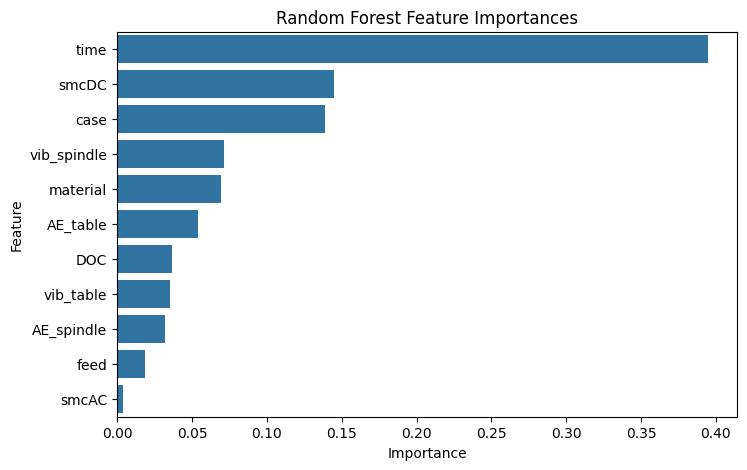

In [89]:
importances = best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy viewing
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df.sort_values('Importance', ascending=False, inplace=True)
print(feat_imp_df)

#Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Random Forest Feature Importances')
plt.show()

# Check For Overfitting as Adjusted R2 is exceptional high ~~ .999

1 ) Check For Data Leakage...

In [ ]:
# Check correlation between features and target
corr_matrix = pd.DataFrame(X_train).corrwith(y_train)
print("\n=== Feature-Target Correlation ===")
print(corr_matrix.sort_values(ascending=False).head(10))

# Check for near-perfect correlation (leakage suspects)
high_corr_features = corr_matrix[abs(corr_matrix) > 0.99]
if not high_corr_features.empty:
    print("\n Warning: Possible leakage in features:", high_corr_features.index.tolist())


=== Feature-Target Correlation ===
time           0.509512
material       0.261059
case           0.252885
AE_spindle     0.023095
smcDC          0.001540
smcAC          0.000366
AE_table       0.000292
vib_table     -0.000268
vib_spindle   -0.001057
feed          -0.019657
dtype: float64


Since none of the features correlation are >1.Thus the possibility of data leakage is  "ZERO"

2)Baseline Accuracy 

In [ ]:
# Train a simple linear regression
baseline = LinearRegression()
baseline.fit(X_train, y_train)

# Evaluate
y_pred_baseline = baseline.predict(X_test)
print("\n=== Baseline Model (Linear Regression) ===")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_baseline)):.6f}")
print(f"R²: {r2_score(y_test, y_pred_baseline):.6f}")

if r2_score(y_test, y_pred_baseline) > 0.99:
    print("Baseline performs similarly . There is daat leakage in the Model.")


=== Baseline Model (Linear Regression) ===
RMSE: 0.260128
R²: 0.000421


3) Sanity Check with Noisy Data

In [ ]:
# Add small noise to features
X_noisy = X_train + np.random.normal(0, 0.05, size=X_train.shape)
y_pred_noisy = best_model.predict(X_noisy)

# Calculate Adjusted R²
n = X_train.shape[0]  # Number of samples
p = X_train.shape[1]  # Number of features
r2_noisy = r2_score(y_train, y_pred_noisy)
adjusted_r2_noisy = 1 - (1 - r2_noisy) * (n - 1) / (n - p - 1)

print("\n=== Sanity Check (Noisy Data) ===")
print(f"Adjusted R² on noisy data: {adjusted_r2_noisy:.6f}")
if adjusted_r2_noisy < 0.99:
    print("Model is brittle to noise. Overfitting likely.")
else:
    print("Model is robust to noise. No overfitting detected.")


=== Sanity Check (Noisy Data) ===
Adjusted R² on noisy data: 0.992748
Model is robust to noise. No overfitting detected.


2)XGBoost MODEL ML MODEL---

In [74]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBRegressor(random_state=2404264, n_jobs=1, verbosity=0)  # Adding validate_parameters to the model initialization
xgb_param_distributions = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    "base_score": [0.5, 0.7],
    "reg_alpha": [0, 0.1, 0.5],
    "gamma": [0, 0.1, 0.5],
    "min_child_weight": [1, 5, 10],
    "max_bin": [2, 5],  # Adding max_delta_step to the parameter grid
    'max_delta_step': [0, 1, 5],  # Adding max_delta_step to the parameter grid}
    'grow_policy': ['depthwise','lossguide']  # Adding grow_policy to the parameter grid

}
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_distributions,
    n_iter=10,
    cv=5,
    random_state=2404264,
    n_jobs=1,
    verbose=1  # Verbosity for better logging
)

In [75]:
xgb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'base_score': [0.5, 0.7], 'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1, ...], 'grow_policy': ['depthwise', 'lossguide'], ...}"
,n_iter,10
,scoring,None
,n_jobs,1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,2404264
,error_score,nan


In [76]:
xgb_best_params = xgb_random_search.best_params_
xgb_best_model = xgb_random_search.best_estimator_

print("Best Hyperparameters:", xgb_best_params)

Best Hyperparameters: {'subsample': 1.0, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 20, 'max_delta_step': 5, 'max_bin': 5, 'learning_rate': 0.01, 'grow_policy': 'depthwise', 'gamma': 0, 'colsample_bytree': 1.0, 'base_score': 0.7}


In [77]:


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions
y_pred = xgb_best_model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Adjusted R2
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f}")
print(f"Adjusted R²: {adjusted_r2:.6f}")

RMSE: 0.085487
MAE: 0.071010
R²: 0.892046
Adjusted R²: 0.892041


<Axes: xlabel='VB', ylabel='Count'>

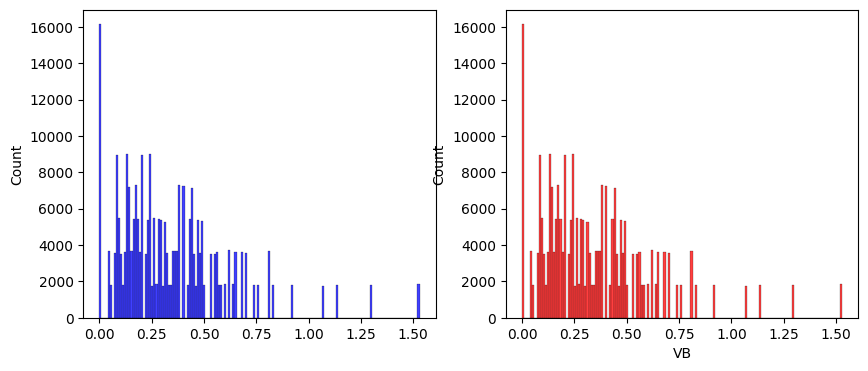

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121); sns.histplot(y_pred, color='blue', label='Predicted')
plt.subplot(122); sns.histplot(y_test, color='red', label='Test')

In [ ]:

# For Random Forest
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluates a regression model calculate MAE and RMSE.

    Parameters
    ----------
    model : object
        Trained regression model with a .predict() method.
        
    X_test : DataFrame
        Test features.
        
    y_test : Series
        True target values.
        
    model_name : str
        Name of the model (for printing purposes). Default is "Model".

    Returns
    -------
    mae : float
        Mean Absolute Error of the predictions.

    rmse : float
        Root Mean Squared Error of the predictions.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{model_name} MAE: {mae:.6f}")
    print(f"{model_name} RMSE: {rmse:.6f}")

    return mae, rmse

mae_rf, rmse_rf = evaluate_model(best_model, X_test, y_test, model_name="Random Forest")
mae_xgb, rmse_xgb = evaluate_model(xgb_best_model, X_test, y_test, model_name="XGBoost")


Random Forest MAE: 0.000488
Random Forest RMSE: 0.001301
XGBoost MAE: 0.000011
XGBoost RMSE: 0.000131


In [90]:
# Comparing actual vs predicted values
pd.DataFrame({'Actual': y_test[:10], 'Predicted': best_model.predict(X_test[:10])})

,Actual,Predicted
131135,0.50,0.497898
707234,0.12,0.121867
463013,0.49,0.488450
364290,0.28,0.279849
107959,0.40,0.398712
1225377,0.32,0.319978
1481930,0.24,0.241504
190968,0.15,0.149906
1021556,0.44,0.452571
84825,0.29,0.290530


# LSTM

In [125]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [126]:
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [128]:
def build_lstm_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    
    """
    Builds and compiles an LSTM-based regression model using Keras.

    Parameters
    ----------
    units : int, optional (default=50)
        Number of units (neurons) in the LSTM layer.

    dropout_rate : float, optional (default=0.2)
        Dropout rate to apply after the LSTM layer for regularization.

    learning_rate : float, optional (default=0.001)
        Learning rate for the Adam optimizer.

    Returns
    -------
    model : keras.Sequential
        A compiled Keras Sequential model for training.
    """
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Regression output

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [129]:
lstm_model = KerasRegressor(build_fn=build_lstm_model,units=50,learning_rate=0.001, dropout_rate=0.2)


In [132]:
param_distributions = {
    'units': [50,100],
    'dropout_rate': [0.2, 0.5],  # Adding dropout_rate to the parameter grid
    'learning_rate': [0.001, 0.01],
    'batch_size': [32],
    'epochs': [30],
    'validation_split': [0.2]  # Adding validation_split to the parameter grid
}



early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
random_search = RandomizedSearchCV(
    estimator=lstm_model,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    verbose=1,
    n_jobs=1,  
    random_state=2404264
)

history=random_search.fit(X_train_lstm,
                  y_train,
                  callbacks=[early_stopping],
                  validation_split=0.2,  # Use a validation split for early stopping
                  )


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/30


d:\project\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
d:\project\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
d:\project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17520/17520 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.0075 - val_loss: 0.0023
Epoch 2/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 3/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 4/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.0019 - val_loss: 8.5395e-04
Epoch 5/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.0018 - val_loss: 5.9868e-04
Epoch 6/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.0017 - val_loss: 3.5010e-04
Epoch 7/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0016 - val_loss: 3.4944e-04
Epoch 8/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0015 - val_loss: 2.7134e-04
Epoch 9/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0015 - val_loss: 4.5943e-04
Epoch 11/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.0014 - v

d:\project\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
d:\project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17520/17520 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 2/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 86s 5ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 3/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 4/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 85s 5ms/step - loss: 0.0019 - val_loss: 7.5517e-04
Epoch 5/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - loss: 0.0018 - val_loss: 6.5496e-04
Epoch 6/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 86s 5ms/step - loss: 0.0016 - val_loss: 5.0689e-04
Epoch 7/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 86s 5ms/step - loss: 0.0016 - val_loss: 4.8328e-04
Epoch 8/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - loss: 0.0015 - val_loss: 3.8625e-04
Epoch 9/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 85s 5ms/step - loss: 0.0015 - val_loss: 2.9122e-04
Epoch 10/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - loss: 0.0014 - val_loss: 2.6397e-04
Epoch 11/30
17520/17520 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - loss: 0.0014

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test_lstm)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Best Hyperparameters:", random_search.best_params_)
print("RMSE:", rmse)
print("R² score:", r2)
aZ